In [27]:
#Leemos el Notebook de Utils
#We read the Utils Notebook
%run Utils.ipynb
plt.style.use('fivethirtyeight')
import collections, functools, operator

In [28]:
path = "C:\\Users\\manub\\DATA\\00-EXTERNO\\MANU\\PHD\\WALKNET\\"

In [29]:
nodes_file = path+"\\SEGOVIA\\nodes_loaded.shp"
edges_file = path+"\\SEGOVIA\\edges_loaded.shp"


In [30]:
edges = gpd.read_file(edges_file)
nodes = gpd.read_file(nodes_file)

In [31]:
def remove_z_line(data_z):
    for i,row in tqdm(data_z.iterrows()):
        a = [coordinate[:2] for coordinate in list(row['geometry'].coords)]
        data_z.at[i,'geometry'] = LineString(a)
    return data_z
def remove_z_point(data_z):
    for i,row in tqdm(data_z.iterrows()):
        #print(row['geometry'].coords[0][:2])
        data_z.at[i,'geometry'] = Point(row['geometry'].coords[0][:2])
    return data_z

In [32]:
edges = remove_z_line(edges)

nodes = remove_z_point(nodes)

In [33]:
edges['time'] = edges[['time_up','time_down']].max(axis=1).astype('int')

In [34]:
#display(edges.head(2))
#display(nodes.head(2))

In [35]:
edges.to_file(path+"\\SEGOVIA\\edges_loaded_flat.shp",driver='ESRI Shapefile')
edges = path+"\\SEGOVIA\\edges_loaded_flat.shp"
nodes.to_file(path+"\\SEGOVIA\\nodes_loaded_flat.shp",driver='ESRI Shapefile')
nodes = path+"\\SEGOVIA\\nodes_loaded_flat.shp"


Generating Graph...

Loading Edge attributes




Loading Node attributes




Graph Ready


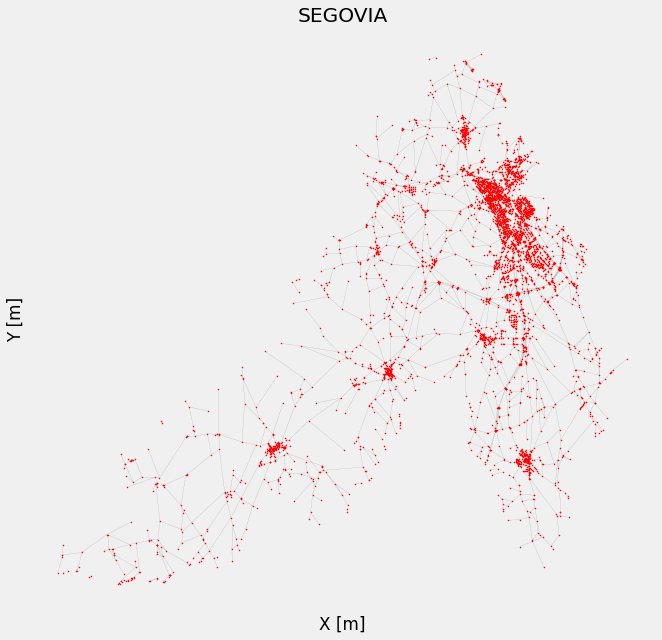

In [36]:
G = create_undirected_from_shp(edges,nodes,'time','SEGOVIA')

In [37]:
sub_graphs = [G.subgraph(c) for c in nx.connected_components(G)]

Text(0.5, 1.0, 'SG')

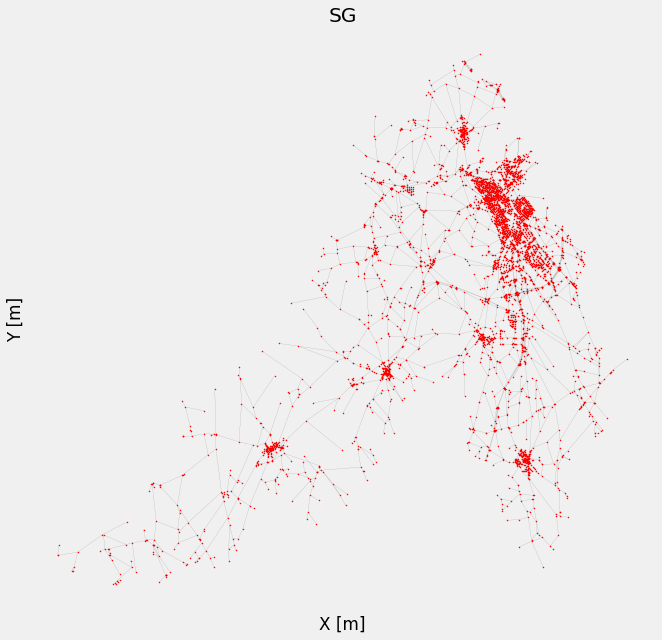

In [43]:
G = sub_graphs[0]
coord = {k: k for k in G.nodes}
plt.figure(figsize = (10,10))
nx.draw_networkx_nodes(G,coord,node_size=1,node_color='r')
nx.draw_networkx_edges(G,coord,style='dashed',width=0.1 )
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.xticks([])
plt.yticks([])
plt.title('SG')

In [45]:
ecfbc = nx.edge_current_flow_betweenness_centrality(G, normalized=True, weight='time', solver='full')

KeyboardInterrupt: 

In [51]:
nx.draw(G, nx.closeness_centrality(G,distance='time'), 'CN Centrality')

AttributeError: 'str' object has no attribute 'get_figure'

In [ ]:
nx.draw(G, nx.betweenness_centrality(G), 'BN Centrality')

In [11]:
name_nodes = {k[0]:k[1]['attr_dict']['netpoint'] for k in list(G.nodes.data()) if k[1]}

coords_nodes = {v: k for k, v in name_nodes.items()}

all_nodes = {k[1]['attr_dict']['netpoint']:k[1]['attr_dict'] for k in list(G.nodes.data()) if k[1]}
all_nodes = {k:{'origins':round(v['origins'],1),'destinations':round(v['destinatio'],1)} for k,v in all_nodes.items()}

In [12]:
#coords_nodes

In [13]:
origins = {k:v for k,v in all_nodes.items() if v['origins']>0}
destinations = {k:v for k,v in all_nodes.items() if v['destinations']>0}

In [14]:
#print(all_nodes)

In [15]:
G = nx.relabel.relabel_nodes(G,name_nodes)

In [16]:
results ={}

In [17]:
#Aquí ya es nodo a nodo para evitar crear objetos gigantes

results_today = {}


for node in tqdm(list(all_nodes.keys())):
    #print("Node: ",node)
    
    #Context
    
    nG = nx.ego_graph(G, node, radius=10, center=True, undirected=False,  distance='weight' )
    
    surrounding_origins = [n[0] for n in list(nG.nodes.data()) if n[0] in origins.keys()]
    surrounding_destinations = [n[0] for n in list(nG.nodes.data()) if n[0] in destinations.keys()]
    
    all_paths_in_surrounding_nodes = list(nx.all_pairs_dijkstra(nG, cutoff=10, weight='weight'))
    
    all_paths_from_node = [p[0] for n,p in all_paths_in_surrounding_nodes if n == node][0]
    all_paths_from_node = {k:round(v,1) for k,v in all_paths_from_node.items() if k !=node}
    
    #Walkable Gravity   
    
    origin_reach_from_node = [all_nodes[k]['origins'] for k,v in all_paths_from_node.items() if k in surrounding_origins]
    destination_reach_from_node = [all_nodes[k]['destinations'] for k,v in all_paths_from_node.items() if k in surrounding_destinations]
    
    origin_reach_from_node = round(sum(origin_reach_from_node),3)
    destination_reach_from_node = round(sum(destination_reach_from_node),3)
    walkable_reach_from_node = round(walkable_trips(origin_reach_from_node,destination_reach_from_node)[0],3)
    
    origin_gravity_from_node = [all_nodes[k]['origins']/(v+1) for k,v in all_paths_from_node.items() if k in surrounding_origins]
    destination_gravity_from_node = [all_nodes[k]['destinations']/(v+1) for k,v in all_paths_from_node.items() if k in surrounding_destinations]
    
    origin_gravity_from_node = round(sum(origin_gravity_from_node),3)
    destination_gravity_from_node = round(sum(destination_gravity_from_node),3)
    walkable_gravity_from_node = round(walkable_trips(origin_gravity_from_node,destination_gravity_from_node)[0],3)                                      
    
    
    origin_norm_gravity_from_node = origin_gravity_from_node / (origin_reach_from_node + 1)
    destination_norm_gravity_from_node = destination_gravity_from_node / (destination_reach_from_node +1)
    walkable_norm_gravity_from_node = walkable_gravity_from_node / (walkable_reach_from_node +1)
    
    #print("Origins in area: ",origin_gravity_from_node)
    #print("Destinations in area: ",destination_gravity_from_node)
    #print("Gravity walkable trips in area: ",walkable_gravity_from_node)
    
    #Walkable Betweeness*
    
    all_shortest_with_origin = [nd for nd in all_paths_in_surrounding_nodes if nd[0] in origins.keys()]
    
    all_meaningful_paths = {}
    
    for n in all_shortest_with_origin:
        paths = {n[0]: ({k:v for k,v in n[1][0].items() if k in destinations.keys()},{k:v for k,v in n[1][1].items() if k in destinations.keys()})}
        all_meaningful_paths.update(paths)

    surrounding_meaningful_paths = {}

    for k,v in all_meaningful_paths.items():
        paths_cost = {str(k)+'|'+str(ki):round(vi,1) for ki,vi in v[0].items() if k != ki}
        paths_route = {str(k)+'|'+str(ki):vi for ki,vi in v[1].items() if k != ki}
        paths = {route:{'cost':paths_cost[route],'route':paths_route[route]} for route in paths_cost.keys()}
        surrounding_meaningful_paths.update(paths)
        
    #print("Routes in surroundings:",len(surrounding_meaningful_paths))
    
    walkable_in_surroundings = round(sum({k:(only_walkable_trips(all_nodes[int(k.split("|")[0])]['origins'],all_nodes[int(k.split("|")[1])]['destinations']))/(v['cost']+1) for k,v in surrounding_meaningful_paths.items()}.values()),3)
    
    #print("Walkable in surroundings: ",walkable_in_surroundings)
    
    through_node_paths = {k:v for k,v in surrounding_meaningful_paths.items() if node in v['route']}
    
    #print("Routes through node:",len(through_node_paths))
    
    if through_node_paths:
        
        walkable_through_node = round(sum({k:(only_walkable_trips(all_nodes[int(k.split("|")[0])]['origins'],all_nodes[int(k.split("|")[1])]['destinations']))/(v['cost']+1) for k,v in through_node_paths.items()}.values()),3)
        
        #print("Walkable through node: ",walkable_through_node)
        
        betweeness = round(walkable_through_node/walkable_in_surroundings,3)
        
        #print("Betweeness: ",betweeness)
    else:
        #print("No Beetweeness")
        walkable_through_node = 0
        betweeness = 0
    
    results_today.update({node:
                          {'netpoint':node,
                           'geometry':Point(coords_nodes[node]),
                           
                           'gravity_origins':origin_gravity_from_node,
                           'gravity_destinations':destination_gravity_from_node,
                           'gravity_walkable':walkable_gravity_from_node,
                           
                           'reach_origins':origin_reach_from_node,
                           'reach_destinations':destination_reach_from_node,
                           'reach_walkable':walkable_reach_from_node,
                           
                           'gravity_origins_norm': origin_norm_gravity_from_node,
                           'gravity_destinations_norm':destination_norm_gravity_from_node,
                           'gravity_walkable_norm': walkable_norm_gravity_from_node,
                           
                           'betweeness_potential':walkable_in_surroundings,
                           'beetweenes_net':walkable_through_node,
                           'betweeness_norm':betweeness}})
    
    #print("............................................................")
    

KeyboardInterrupt: 

In [ ]:
#results_today

In [ ]:
df = pd.DataFrame.from_dict(results_today,orient='index')
gdf = gpd.GeoDataFrame(df,geometry='geometry')
#gdf.to_csv(path+"\\SEGOVIA\\results_today3.csv",sep=";")

In [ ]:
gdf.to_csv(path+"\\SEGOVIA\\results_today_15.csv",sep=";")

In [ ]:
all_paths_from_nodes = list(nx.all_pairs_dijkstra(G, cutoff=1500, weight='weight'))

In [ ]:
all_shortest_with_origin = [node for node in all_paths_from_nodes if node[0] in origins.keys()]
all_meaningful_paths = {}
for node in all_shortest_with_origin:
    paths = {node[0]: ({k:v for k,v in node[1][0].items() if k in destinations.keys()},{k:v for k,v in node[1][1].items() if k in destinations.keys()})}
    all_meaningful_paths.update(paths)

final_meaningful_paths = {}

for k,v in all_meaningful_paths.items():
    paths_cost = {str(k)+'|'+str(ki):round(vi,1) for ki,vi in v[0].items() if k != ki}
    paths_route = {str(k)+'|'+str(ki):vi for ki,vi in v[1].items() if k != ki}
    paths = {route:{'cost':paths_cost[route],'route':paths_route[route]} for route in paths_cost.keys()}
    final_meaningful_paths.update(paths)


In [ ]:
all_paths = []
for node in tqdm(all_paths_from_nodes):   
    origin = node[0]
    for destination in node[1][0]:
        if origin in all_nodes.keys() and destination in all_nodes.keys() and origin!=destination:
        #dest = all_nodes[destination]
            path = [n for n in node[1][1][destination]]
            cost = round(node[1][0][destination],1)
            ecost = round(Point(coords_nodes[origin]).distance(Point(coords_nodes[destination])),1)
            gen = round(all_nodes[origin]['origins'],1)
            att = round(all_nodes[destination]['destinatio'],1)
            wt = walkable_trips(gen,att)
            kst = round(ecost/cost,2)
            wt_pwr = round(wt[0]/cost,2) 
            wt_pwst = round((wt[0]*kst)/cost,2)
            un_pwr = round(wt[1]/cost,2) 
            un_pwst = round((wt[1]*kst)/cost,2)
            path_dict = {
                'origin':origin,
                'destination':destination,
                'path': path,
                'cost': cost,
                'ecost': ecost,
                'generated': gen,
                'attracted': att,
                'walkable': wt[0],
                'unpaired': wt[1],
                'unpairedc': wt[2],
                'str_coeff': kst,
                'walkable': wt_pwr,
                'str_walkable': wt_pwst,
                'unpaired': un_pwr,
                'str_unpaired':un_pwst}
            all_paths.append(path_dict)
        else:
            pass

loaded_paths = [d for d in tqdm(all_paths) if d['generated'] != 0 or d['attracted'] != 0]
print(len(loaded_paths))
                                

In [ ]:
#all_possible_paths_from_nodes = {'origin':all_nodes[n[0]]['netpoint'],'destination':p[0] for n,d in all_paths_from_nodes}

In [ ]:
len(all_paths)

In [ ]:
#Primero cada diccionario aplicado a la ruta entera por la que atraviesa
dict_nodes = []
loaded_nodes = []
for p in tqdm(loaded_paths):
    for n in p['path']:
        d = p
        d['node'] = n
        dict_nodes.append(d)
        loaded_nodes.append(n)
    #print("................")
loaded_nodes = list(set(loaded_nodes))

In [ ]:
#Despues, una lista de diccionarios para cada nodo
final_nodes = []
for node in tqdm(loaded_nodes[0:2]):
    dicts = [{'walkable':d['walkable'],'str_walkable':d['str_walkable'],'unpaired':d['unpaired'],'str_unpaired':d['str_unpaired']} for d in dict_nodes if d['node'] == node]
    if dicts:
        result = dict(functools.reduce(operator.add,map(collections.Counter, dicts)))
        result['netpoint']=node
        print(result)
        final_nodes.append(result)
    else:
        print("node "+str(node)+" not found")
        pass
    #print("..........")

In [ ]:
print(loaded_)

In [ ]:
print("CORRIO HASTA AQUI")

In [ ]:
df_final_nodes = pd.DataFrame(final_nodes)
nodes = gpd.read_file(nodes_file).set_index('netpoint')

In [ ]:
display(df_final_nodes.head(5000))

In [ ]:
result_nodes = pd.merge(nodes,df_final_nodes,how='outer',left_index=True,right_index=True)

In [ ]:
result_nodes.to_file(path+"\\SEGOVIA\\nodes_centrality1500.geojson",driver='GeoJSON')

In [ ]:
df_final_nodes.head(5)

In [ ]:
nodes.head()

In [ ]:
valid_nodes=[node for node in G.nodes(data = True)if node[1]]
gravity={}
for node in tqdm(valid_nodes):
    data={}
    service_area = nx.ego_graph(G, node[0], radius = 500, center=True, distance = 'weight')
    reachable_nodes = [rnode for rnode in service_area.nodes(data = True) if rnode[0] != node[0] and rnode[1]]
    gravity_in_node = {}
    for r in reachable_nodes:
        path = nx.dijkstra_path(service_area, node[0], r[0], weight='weight')
        distance = nx.shortest_path_length(service_area, node[0], r[0], weight='weight')
        result_this_path = {r[0]:{'GrOri':(r[1]['attr_dict']['origins'])/distance,'GrDes':(r[1]['attr_dict']['destinatio'])/distance}}
        gravity_in_node.update(result_this_path)
        result = pd.DataFrame.from_dict(gravity_in_node, orient='index')
        r = result.sum(axis = 0, skipna = True)
        data.update({node[1]['attr_dict']['netpoint']:{'GrOri':r[0],'GrDes':r[1]}})

    gravity.update(data)

In [ ]:
betweeness={}
for node in tqdm(valid_nodes):
    data = []
    service_area = nx.ego_graph(G, node[0], radius = 500, center=True, distance = 'weight')
    reachable_nodes = [rnode for rnode in service_area.nodes(data = True) if rnode[0] != node[0] and rnode[1]]
    origins = [rnode for rnode in reachable_nodes if rnode[1]['attr_dict']['origins'] > 0]
    destinations = [rnode for rnode in reachable_nodes if rnode[1]['attr_dict']['destinatio'] > 0]
    for o in origins:
        for d in destinations:
            dest = d[0]
            path_od = nx.single_source_dijkstra(service_area, o[0], dest, weight='weight')
            if path_od[0] <= 100 and node[0] in path_od[1]:
                norigins = o[1]['attr_dict']['origins']
                ndestinations = d[1]['attr_dict']['destinatio']
                wt = walkable_trips(norigins,ndestinations)
                bt = (wt[0]/path_od[0],wt[1]/path_od[0],wt[2])
                data.append(bt)
            else:
                pass
    btwt = sum([a[0] for a in data])
    btun = sum([a[1] for a in data])
    btun_o = sum([a[1] for a in data if a[2] == 'ORIGINS'])
    btun_d = sum([a[1] for a in data if a[2] == 'DESTINATIONS'])
    m = max(btun_o, btun_d)
    if m == btun_o:
        btunc = 'ORIGINS'
    else:
        btunc = 'DESTINATIONS'
    this_node_betweeness = {node[1]['attr_dict']['netpoint']:{'BtWt': btwt ,'BtUn':btun,'BtUnC':btunc}}

    betweeness.update(this_node_betweeness)

In [ ]:
df_gravity = pd.DataFrame.from_dict(gravity,orient='index')
df_betweeness = pd.DataFrame.from_dict(betweeness,orient='index')

In [ ]:
display(df_gravity.head())
display(df_betweeness.head())

In [ ]:
nodes = gpd.read_file(nodes)

In [ ]:
display(nodes.head(200))

In [ ]:
final_nodes = pd.concat([nodes,df_gravity,df_betweeness], axis=1)

In [ ]:
display(final_nodes.head())

In [ ]:
def walkable_trips_nodes(data,origins,destinations):
    for i,row in tqdm(data.iterrows()):
        if row[origins] == 0 and row[destinations] == 0:
            data.at[i,'GrWt'] =  0
            data.at[i,'GrUn'] =  0
            data.at[i,'GrUnc'] =  'NULL'
        elif row[origins] <= row[destinations]:
            data.at[i,'GrWt'] =  row[origins]
            data.at[i,'GrUn'] =  row[destinations] - row[origins]
            data.at[i,'GrUnc'] =  'DESTINATIONS'
        elif row[origins] >= row[destinations]:
            data.at[i,'GrWt'] =  row[destinations]
            data.at[i,'GrUn'] =   row[origins] - row[destinations] 
            data.at[i,'GrUnc'] =  'ORIGINS'
    return data

In [ ]:
final_nodess = walkable_trips_nodes(final_nodes,'GrOri','GrDes')

In [ ]:
display(final_nodess.head(5))

In [ ]:
final_nodess.to_file(path+"\\SEGOVIA\\nodes_centrality1500.geojson",driver='GeoJSON')


In [ ]:
#all_nodes = {k[0]:k[1]['attr_dict'] for k in list(G.nodes.data()) if k[1]}